# Convolutional XGBoost

## 1. Packages

In [1]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.models import load_model
from keras.utils import np_utils
from matplotlib import pyplot as plt
import os
import cv2
import imghdr
import numpy as np
import cv2
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

## 2. GPU Allocation

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3. Data from Kaggle

In [4]:
os.environ['KAGGLE_USERNAME'] = 'taylancicek' # kaggle API username
os.environ['KAGGLE_KEY'] = 'f95dc0c7836807c24b6446cba0fc0f9c' # kaggle API key
! kaggle datasets download -d mostafaabla/garbage-classification

100% 239M/239M [00:08<00:00, 37.3MB/s]
100% 239M/239M [00:08<00:00, 31.2MB/s]


In [5]:
file_name = "/content/garbage-classification.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [6]:
import shutil
dir = "/content/garbage_classification/"
trash_list = ['trash', 'clothes', 'battery', 'shoes']
recyc_list = ['plastic', 'brown-glass', 'white-glass', 'cardboard', 'green-glass', 'metal', 'paper']
comp_list = ['biological']
for folder in os.listdir(dir):
  if folder in trash_list:
    dir_path = dir + 'trash/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in recyc_list:
    dir_path = dir + 'recyc/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in comp_list:
    dir_path = dir + 'comp/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)

for folder in os.listdir(dir):
  if folder not in ['trash', 'recyc', 'comp']:
    os.rmdir(dir + folder)

In [7]:
num_class = len(list(os.listdir(dir)))

## 4. Loading Data

In [8]:
data = tf.keras.utils.image_dataset_from_directory(directory = '/content/garbage_classification',
                                                           labels = 'inferred',
                                                           image_size = (256, 256))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 15515 files belonging to 3 classes.


In [9]:
data = data.map(lambda x,y: (x/255, y))

## 5. Data Split

In [10]:
train_size = int(round(len(data)*.5,0))
val_size = int(round(len(data)*.3,0))
test_size = int(round(len(data)*.2,0))

In [11]:
val = data.take(val_size)
train = data.skip(val_size).take(train_size)
test = data.skip(train_size+val_size).take(test_size)

In [12]:
y_train = np.concatenate([y for x, y in train], axis=0)
y_val = np.concatenate([y for x, y in val], axis=0)
y_test = np.concatenate([y for x, y in test], axis=0)

## 6. CNN Model

In [13]:
np.random.seed(1337) 

In [14]:
# Another way to build your CNN
inputs = Input(shape=(256, 256, 3))

conv2d1 = Conv2D(filters=64, 
                 kernel_size=5, 
                 padding='same')(inputs)

activation1 = Activation('relu')(conv2d1)

maxpooling1 = MaxPooling2D(pool_size=2, 
                           strides=2, 
                           padding='same')(activation1)

dropout1 = Dropout(0.25)(maxpooling1)

conv2d2 = Conv2D(filters=64, 
                 kernel_size=4, 
                 padding='same')(dropout1)

activation2 = Activation('relu')(conv2d2)

maxpooling2 = MaxPooling2D(pool_size=2, 
                           strides=2, 
                           padding='same')(activation2)

flatten = Flatten()(maxpooling2)

dense1 = Dense(1024)(flatten)
activation3 = Activation('relu')(dense1)

dense2 = Dense(num_class)(activation3)
activation4 = Activation('softmax')(dense2)

model_dense2_output = Model(inputs=inputs, outputs=activation3)
model = Model(inputs=inputs, outputs=activation4)

In [15]:
adam = Adam(lr=1e-4)

# We add metrics to get more results you want to see
model.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

hist = model.fit(train,
                 epochs=20, 
                 validation_data = val)

loss, accuracy = model.evaluate(test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Epoch 1/20
242/242 [==============================] - 85s 281ms/step - loss: 0.9672 - accuracy: 0.6801 - val_loss: 0.7661 - val_accuracy: 0.7410
Epoch 2/20
242/242 [==============================] - 74s 283ms/step - loss: 0.5286 - accuracy: 0.7629 - val_loss: 0.6505 - val_accuracy: 0.7547
Epoch 3/20
242/242 [==============================] - 75s 282ms/step - loss: 0.4388 - accuracy: 0.8108 - val_loss: 0.6535 - val_accuracy: 0.6993
Epoch 4/20
242/242 [==============================] - 79s 299ms/step - loss: 0.3514 - accuracy: 0.8524 - val_loss: 0.5716 - val_accuracy: 0.7556
Epoch 5/20
242/242 [==============================] - 76s 292ms/step - loss: 0.2820 - accuracy: 0.8856 - val_loss: 0.5777 - val_accuracy: 0.7633
Epoch 6/20
242/242 [==============================] - 80s 303ms/step - loss: 0.1999 - accuracy: 0.9267 - val_loss: 0.5520 - val_accuracy: 0.7855
Epoch 7/20
242/242 [==============================] - 77s 296ms/step - loss: 0.1546 - accuracy: 0.9463 - val_loss: 0.5956 - val_ac

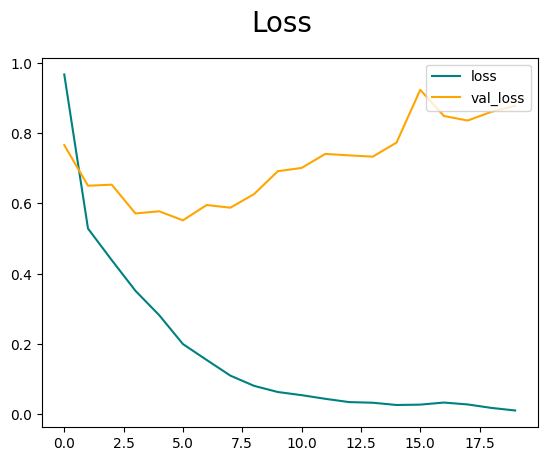

In [16]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

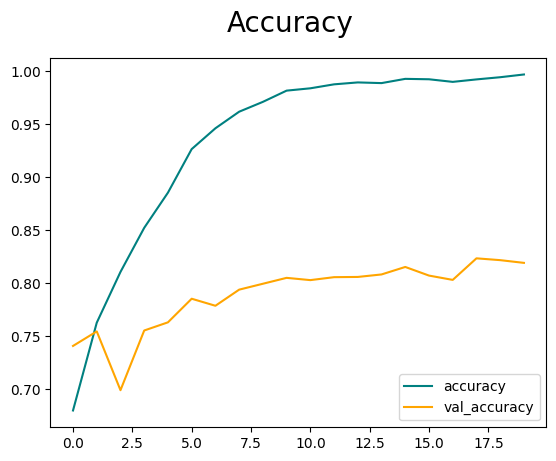

In [17]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [18]:
model_dense2_output.save('/content/CNN_2_XG_FinalDenseLayer.h5')
model.save('/content/CNN_XG_Classification_3Class_2.h5')

## XGBoost

In [20]:
import xgboost
import pandas as pd
import numpy as np
from sklearn import metrics

In [21]:
train_xg = model_dense2_output.predict(train)
val_xg = model_dense2_output.predict(val)
test_xg = model_dense2_output.predict(test)

97/97 [==============================] - 21s 46ms/step


In [22]:
train_xg.shape, val_xg.shape, test_xg.shape

((7744, 1024), (4672, 1024), (3099, 1024))

In [23]:
z = np.concatenate([np.array(train_xg).reshape(train_xg.shape[0],train_xg.shape[1]),np.array(y_train).reshape(train_xg.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('train_xg.csv',index=False)

z = np.concatenate([np.array(val_xg).reshape(val_xg.shape[0],val_xg.shape[1]),np.array(y_val).reshape(val_xg.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('val_xg.csv',index=False)

z = np.concatenate([np.array(test_xg).reshape(test_xg.shape[0],test_xg.shape[1]),np.array(y_test).reshape(test_xg.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('test_xg.csv',index=False)

In [24]:
y_index = str(train_xg.shape[1])

train = pd.read_csv('train_xg.csv')
train_y = train[y_index].astype('int')
train_x = train.drop([y_index],axis=1)
dataset = xgboost.DMatrix(train_x, label=train_y)

val = pd.read_csv('val_xg.csv')
val_y = val[y_index].astype('int')
val_x = val.drop([y_index],axis=1)
val_set = xgboost.DMatrix(val_x, label=val_y)

In [26]:
watchlist = [(val_set,'eval'), (dataset,'train')]
evals_result = {}
params = {'max_depth':8, 
          'learning_rate':0.3, 
          'verbosity':2, 
          'num_class':num_class,
          'objective':'multi:softmax',
          'eval_metric': 'merror',
          'objective': 'multi:softmax'}
model_xg = xgboost.train(params, 
                         dataset, 
                         num_boost_round=50, 
                         evals=watchlist, 
                         evals_result=evals_result)

[18:45:42] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[18:45:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=8
[18:45:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-merror:0.44349	train-merror:0.34065
[18:45:44] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=8
[18:45:44] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=8
[18:45:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-merror:0.43707	train-merror:0.31534
[18:45:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=8
[18:45:46] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[18:45:47

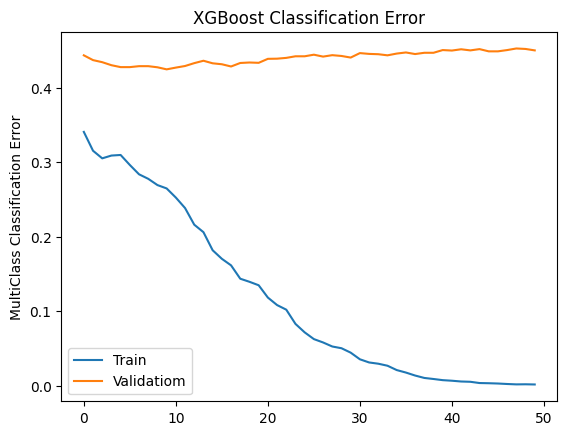

In [27]:
results = evals_result
epochs = len(results['eval']['merror'])
x_axis = range(0, epochs)
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['merror'], label='Train')
ax.plot(x_axis, results['eval']['merror'], label='Validatiom')
ax.legend()
plt.ylabel('MultiClass Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [28]:
test = pd.read_csv('test_xg.csv')
test_y = test[y_index].astype('int')
test_x = test.drop([y_index],axis=1)

test_x = xgboost.DMatrix(test_x)
result = model_xg.predict(test_x)

print(metrics.classification_report(test_y, result))
print(metrics.confusion_matrix(test_y, result))

              precision    recall  f1-score   support

           0       0.08      0.01      0.01       192
           1       0.35      0.18      0.24      1128
           2       0.57      0.80      0.67      1779

    accuracy                           0.53      3099
   macro avg       0.33      0.33      0.31      3099
weighted avg       0.46      0.53      0.47      3099

[[   1   45  146]
 [   6  208  914]
 [   6  349 1424]]


In [29]:
model_xg.save_model("XG_WithCNN.json")

In [30]:
predict_dict = {0: 'comp',
                1: 'recyc',
                2: 'trash'}

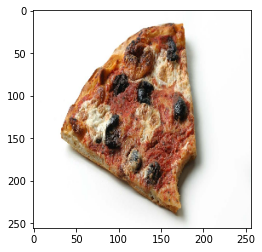

In [ ]:
img = cv2.imread('/content/old-pizza.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

### Prediction with CNN

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
predict_dict[int(np.argmax(yhat, axis = 1))]

1/1 [==============================] - 0s 34ms/step


'trash'

### Prediction with CNN-XGBoost

In [ ]:
my_data = tf.keras.utils.image_dataset_from_directory(directory = '/content/testing',
                                                           labels = None,
                                                           image_size = (256, 256))

Found 4 files belonging to 1 classes.


In [ ]:
batch = my_data.as_numpy_iterator().next() / 255

In [ ]:
my_data = model_dense2_output.predict(batch)

1/1 [==============================] - 0s 265ms/step


In [ ]:
my_data = pd.DataFrame(my_data)
my_data = xgboost.DMatrix(my_data, label=None)

In [ ]:
model_xg.predict(my_data)

array([2., 1., 2., 2.], dtype=float32)

In [ ]:
[predict_dict[int(x)] for x in model_xg.predict(my_data)]

['trash', 'recyc', 'trash', 'trash']